In [134]:
import tensorflow.compat.v1 as tf
from tensorflow import feature_column
from tensorflow.keras import layers
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers # 케라스의 옵티마이저를 임포트

%matplotlib inline

In [135]:
#데이터를 pandas를 이용해 읽어옵니다.
dog_data=pd.read_csv("doginfo_mmy.csv")
kindCd=pd.read_csv("kindCd.csv")

#값이 없는 열 삭제
dog_data = dog_data.dropna(axis=0)
kindCd_data = kindCd.dropna(axis=0)

In [136]:
#품종코드 데이터 numpy배열로 저장
kindCd = np.array(kindCd_data, dtype = np.float64)

kindCd = kindCd.reshape(177)

In [137]:
# kindNum을 원핫 인코딩
kindCd = pd.concat((pd.get_dummies(dog_data.kindNum, columns=kindCd), pd.DataFrame(columns=kindCd))).fillna(0)


# 학습데이터에서 kindNum 열을 삭제한 후, 원핫 인코딩된 kindCd를 붙임
dog_data.drop(['kindNum'], axis='columns', inplace=True)
dog_data = pd.concat([dog_data, kindCd], axis=1)

In [138]:
#더미변수-원-핫인코딩
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis = 1)
        data = data.drop(column, axis = 1)
    return data

In [139]:
#중성화여부, 성별 원-핫 인코딩
dummy_columns = ["neuterYn", "sexCd"]
data = dummy_data(dog_data, dummy_columns)
print(data)

data = np.array(data, dtype = np.float64)

from sklearn.model_selection import train_test_split
#훈련, 검증, 테스트 샘플로 데이터 나누기
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

      weight  noticeDays  age2  processState  1.0  2.0  3.0  4.0  5.0  6.0  \
0       7.46          10    12             0    0    0    0    0    0    0   
1       7.00          14     1             1    0    0    0    0    0    0   
2       4.50          11     2             0    0    0    0    0    0    0   
3      10.00           8     1             0    0    0    0    0    0    0   
4       6.00           8     4             0    0    0    0    0    0    0   
...      ...         ...   ...           ...  ...  ...  ...  ...  ...  ...   
1994    0.98          10     0             1    0    0    0    0    0    0   
1995    1.20          10     0             1    0    0    0    0    0    0   
1996   50.00          10     3             1    0    0    0    0    0    0   
1997    9.00          10     3             0    0    0    0    0    0    0   
1998   12.50          10     3             0    0    0    0    0    0    0   

      ...  208.0  209.0  210.0  211.0  neuterYn_N  neuterYn_U  

In [140]:
#numpy 배열에서 데이터 변화요인(kindCd, neuterYn, sexCd, weight, noticeDays, age2)으로 사용할 데이터를 뽑아냅니다.
a = train[:, :3]
b = train[:, 4:]
xData = np.concatenate([a, b], axis = 1)

a=test[:, :3]
b=test[:, 4:]
testX=np.concatenate([a, b], axis = 1)

a=val[:, :3]
b=val[:, 4:]
valX=np.concatenate([a, b], axis = 1)


In [141]:
#numpy배열에서 결과(입양여부)로 사용할 데이터를 뽑아냅니다.
yData=train[:,[3]]
testY=test[:,[3]]
valY=val[:,[3]]

print(yData)
type(yData)
yData.dtype

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


dtype('float64')

Train on 1276 samples, validate on 320 samples
Epoch 1/50
1276/1276 [==============================] - 3s 3ms/sample - loss: 0.9487 - acc: 0.5815 - binary_crossentropy: 0.6773 - val_loss: 0.7899 - val_acc: 0.5813 - val_binary_crossentropy: 0.6698
Epoch 2/50
1276/1276 [==============================] - 1s 1ms/sample - loss: 0.7515 - acc: 0.6097 - binary_crossentropy: 0.6661 - val_loss: 0.7253 - val_acc: 0.6219 - val_binary_crossentropy: 0.6610
Epoch 3/50
1276/1276 [==============================] - 1s 837us/sample - loss: 0.7135 - acc: 0.6199 - binary_crossentropy: 0.6577 - val_loss: 0.7034 - val_acc: 0.6562 - val_binary_crossentropy: 0.6543
Epoch 4/50
1276/1276 [==============================] - 1s 849us/sample - loss: 0.6978 - acc: 0.6411 - binary_crossentropy: 0.6508 - val_loss: 0.7011 - val_acc: 0.6000 - val_binary_crossentropy: 0.6570
Epoch 5/50
1276/1276 [==============================] - 2s 1ms/sample - loss: 0.6853 - acc: 0.6513 - binary_crossentropy: 0.6417 - val_loss: 0.6741 -

1276/1276 [==============================] - 1s 962us/sample - loss: 0.6198 - acc: 0.7030 - binary_crossentropy: 0.5866 - val_loss: 0.5917 - val_acc: 0.7250 - val_binary_crossentropy: 0.5583
Epoch 42/50
1276/1276 [==============================] - 2s 1ms/sample - loss: 0.6226 - acc: 0.6951 - binary_crossentropy: 0.5898 - val_loss: 0.5855 - val_acc: 0.7344 - val_binary_crossentropy: 0.5520
Epoch 43/50
1276/1276 [==============================] - 1s 999us/sample - loss: 0.6210 - acc: 0.6810 - binary_crossentropy: 0.5870 - val_loss: 0.6547 - val_acc: 0.6125 - val_binary_crossentropy: 0.6217
Epoch 44/50
1276/1276 [==============================] - 1s 914us/sample - loss: 0.6255 - acc: 0.6881 - binary_crossentropy: 0.5929 - val_loss: 0.5876 - val_acc: 0.7281 - val_binary_crossentropy: 0.5552
Epoch 45/50
1276/1276 [==============================] - 1s 850us/sample - loss: 0.6183 - acc: 0.6865 - binary_crossentropy: 0.5855 - val_loss: 0.5882 - val_acc: 0.7156 - val_binary_crossentropy: 0.5555

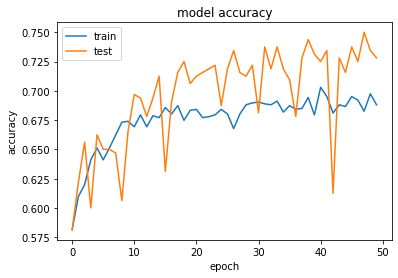

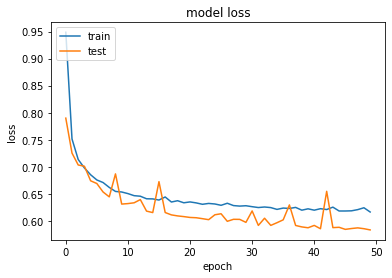

In [142]:
# L2규제
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu, input_shape=(186,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu, input_shape=(186,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.01),
                       activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

Nadam = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

l2_model.compile(optimizer='Nadam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', 'binary_crossentropy'])

l2_model_history = l2_model.fit(xData, yData,
                                epochs=50,
                                batch_size=5,
                                validation_data=(valX, valY),
                                verbose=1)

loss_and_metric = l2_model.evaluate(testX, testY, batch_size=10, verbose=0)
print("train, loss and metric: {}".format(loss_and_metric))

#정확도 그래프
plt.plot(l2_model_history.history['acc'])
plt.plot(l2_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#손실 그래프
plt.plot(l2_model_history.history['loss'])
plt.plot(l2_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

l2_model.save('l2_model_Nadam')
